In [2]:
import numpy as np
import time
import math
import random
import glob
from scipy import linalg as LA
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import sampler
import torchvision.transforms as T

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
float = np.vectorize(float)

def read_file(file_name):
    data = []
    with open(file_name, "r") as f:
        for line in f:
            item = line.strip().split(",")
            data.append(float(item))
    return data

In [4]:
#I = glob.glob('DL Project/20-dim data (41) representation sigma=0.3/*.csv', recursive=True)
#I = glob.glob('DL Project/20-dim data (41) representation old distamce/*.csv', recursive=True)
#I = glob.glob('DL Project/50-dim data (41) representation sigma=0.25/*.csv', recursive=True)
I = glob.glob('DL Project/50-dim data (41) representation sigma=1000/*.csv', recursive=True)
#I = glob.glob('DL Project/50-dim data (41) representation old distamce/*.csv', recursive=True)
#I = glob.glob('DL Project/250-dim data (41) representation sigma=1/*.csv', recursive=True)
#I = glob.glob('DL Project/250-dim data (41) representation old distamce/*.csv', recursive=True)


In [5]:
r = len(I)
r

41

In [6]:
data_embed = [0] * r

for i in range(r):
    data_embed[i] = [len(np.array(read_file(I[i]))), np.array(read_file(I[i]))]

data_embed = np.array(data_embed)
#data_embed = data_embed[data_embed[:,0].argsort()]

In [7]:
X_train = [0] * r
X_test = [0] * r
y_train = [0] * r
y_test = [0] * r

for i in range(r):
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(np.array(data_embed[i][1]), 
                                                                np.ones(len(data_embed[i][1])), 
                                                                test_size=0.3, 
                                                                random_state=109)

In [8]:
for i in range(r):
    X_train[i] = torch.tensor(X_train[i])
    X_test[i] = torch.tensor(X_test[i])
    y_train[i] = torch.tensor(y_train[i])
    y_test[i] = torch.tensor(y_test[i])

In [9]:
X_train[0][0]

tensor([ 8.3486e-05, -1.6719e-05, -1.3998e-04, -2.0105e-04, -2.2536e-04,
        -2.6060e-04, -2.1736e-04, -1.5355e-04, -3.9396e-05, -5.4392e-06,
        -3.5594e-05, -9.4164e-05, -1.4461e-04, -1.5219e-04, -7.8480e-05,
        -6.2985e-05, -1.3133e-04, -3.1368e-04, -3.1661e-04, -4.2472e-04,
        -4.0890e-04, -2.9497e-04, -2.5576e-04, -1.2452e-04, -2.2038e-04,
         1.3053e-04,  3.8230e-04,  3.0821e-04,  5.7134e-04,  2.6316e-04,
         2.6310e-05, -1.1681e-04, -3.4364e-04, -6.2630e-04, -6.3422e-04,
        -3.6071e-04,  6.8906e-05, -3.4059e-04, -6.9094e-04, -1.0120e-03,
        -1.3365e-03, -1.4892e-03, -1.7201e-03, -5.7177e-04,  2.8795e-04,
        -3.8456e-04, -1.5549e-04, -1.5005e-04, -4.7357e-04,  7.6625e-05],
       dtype=torch.float64)

In [16]:
A = data_embed[:,0]
A = np.sort(A)

In [17]:
print(A)

[100 101 106 108 112 113 120 133 144 146 147 148 150 150 154 160 167 173
 182 196 196 207 215 226 260 275 295 318 371 382 389 394 407 423 544 583
 678 747 800 2014 2124]


# 1-Layer Fully Connected Network

## 10 Class Classification

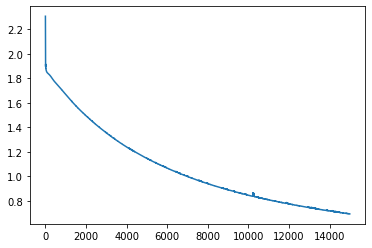

In [35]:
Start_time = time.time()

mean_train_error = 0
mean_test_error = 0
var_test_error = 0

lr_decay = 0.7
num_trials = 1
learning_rate = 1e-2
Num_updates = 15000
losses = torch.zeros(num_trials, r-9, Num_updates)

for s in range(num_trials):

    error_train_list_all = []
    error_test_list_all = []

    Start_time_2 = time.time()

    for i in range(r-9): 

        x = torch.cat((X_train[i], X_train[i+1], X_train[i+2], X_train[i+3], 
                       X_train[i+4],X_train[i+5], X_train[i+6], X_train[i+7],
                       X_train[i+8], X_train[i+9]), 0).float()
        y = torch.cat((0 * y_train[i], y_train[i+1], 2 * y_train[i+2], 3 * y_train[i+3],
                       4 * y_train[i+4], 5 * y_train[i+5], 6 * y_train[i+6], 7* y_train[i+7],
                       8 * y_train[i+8], 9 * y_train[i+9]), 0).long()

        D_in = len(x[0]) # D_in is input dimension
        H = 200 # H is the dimension of hidden layer
        D_out = 10 # D_out is output dimension

        model = torch.nn.Sequential(
                                    torch.nn.Linear(D_in, H),
                                    torch.nn.LeakyReLU(0.01),
                                    #torch.nn.ReLU(),
                                    #torch.nn.Tanh(),
                                    #torch.nn.Dropout(p=q),
                                    torch.nn.Linear(H, D_out)
                                    )

        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        for t in range(Num_updates):
            y_pred = model(x) # of shape (N,D_out)
            #print(torch.argmax(y_pred, 1))
            loss = loss_fn(y_pred, y)
            losses[s, i, t] = loss

            #if t % 1000 == 0:
            #    print(t, loss.item())
                
            if (t+1) % 400 == 0:
                optimizer.param_groups[0]['lr'] = lr_decay * learning_rate

            optimizer.zero_grad()

            loss.backward() # Backward pass

            optimizer.step()  # Calling the step function on the Optimizer 

        X = torch.cat((X_test[i], X_test[i+1], X_test[i+2], X_test[i+3], 
                       X_test[i+4],X_test[i+5], X_test[i+6], X_test[i+7],
                       X_test[i+8], X_test[i+9]), 0).float()
        Y = torch.cat((0 * y_test[i], y_test[i+1], 2 * y_test[i+2], 3 * y_test[i+3],
                       4 * y_test[i+4], 5 * y_test[i+5], 6 * y_test[i+6], 7* y_test[i+7],
                       8 * y_test[i+8], 9 * y_test[i+9]), 0).long()
        
        Y_pred = model(X)
        
        error_train_list_all.append((torch.argmax(y_pred, 1) != y).sum().float()/len(y))
        error_test_list_all.append((torch.argmax(Y_pred, 1) != Y).sum().float()/len(Y))

    mean_train_error += np.mean(error_train_list_all)
    mean_test_error += np.mean(error_test_list_all)
    var_test_error += np.var(error_test_list_all)

mean_train_error /= num_trials
mean_test_error /= num_trials
var_test_error /= num_trials

plt.plot((torch.mean(losses[0], dim=0)).detach().numpy())
plt.show()

### New Distance, $|Q|=20$, $\sigma=0.3$

In [27]:
print('|Q|=20,', 'sigma = 0.3,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = LeakyReLU(0.01),", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["FC 1-Layer", 10, H, None, learning_rate, "len(x)", 
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Num_classes', 'Hidden dim', 
                                       'Drop Out p', 'Learning Rate',
                                       'Batch Normalization', 'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=20, sigma = 0.3, Number of Users:  41, Number of Trials =  1
Activation = LeakyReLU(0.01), Learning Decay = 0.5 , Number of Updates =  10000


,Classifier,Num_classes,Hidden dim,Drop Out p,Learning Rate,Batch Normalization,Train Error,Test Error,Variance Error
1,FC 1-Layer,10,200,None,0.1,len(x),0.2352,0.4007,0.005


### Old Distance, $|Q|=20$

In [18]:
print('|Q|=20,', 'Old Distance,', "Number of Users: ", "41,", 
      'Number of Trials = ', num_trials)
print("Activation = LeakyReLU(0.01),", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["FC 1-Layer", 10, H, None, learning_rate, "len(x)", 
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Num_classes', 'Hidden dim', 
                                       'Drop Out p', 'Learning Rate',
                                       'Batch Normalization', 'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=20, Old Distance, Number of Users:  41, Number of Trials =  1
Activation = LeakyReLU(0.01), Learning Decay = 0.9 , Number of Updates =  5000


,Classifier,Num_classes,Hidden dim,Drop Out p,Learning Rate,Batch Normalization,Train Error,Test Error,Variance Error
1,FC 1-Layer,10,20,None,0.007,len(x),0.3246,0.3275,0.0029


### New Distance, $|Q|=50$, $\sigma=0.25$

In [16]:
print('|Q|=50,', 'sigma = 0.25,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = LeakyReLU(0.01),", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["FC 1-Layer", 10, H, None, learning_rate, "len(x)", 
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Num_classes', 'Hidden dim', 
                                       'Drop Out p', 'Learning Rate',
                                       'Batch Normalization', 'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=50, sigma = 0.25, Number of Users:  41, Number of Trials =  1
Activation = LeakyReLU(0.01), Learning Decay = 0.9 , Number of Updates =  500


,Classifier,Num_classes,Hidden dim,Drop Out p,Learning Rate,Batch Normalization,Train Error,Test Error,Variance Error
1,FC 1-Layer,10,50,None,0.02,len(x),0.0493,0.4899,0.0069


### New Distance, $|Q|=50$, $\sigma=1000$

In [37]:
print('|Q|=50,', 'sigma = 1000,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = LeakyReLU(0.01),", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["Fully Connected 1-Layer", 10, H, None, learning_rate, "len(x)", 
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Num_classes', 'Hidden dim', 
                                       'Drop Out p', 'Learning Rate',
                                       'Batch Normalization', 'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=50, sigma = 1000, Number of Users:  41, Number of Trials =  1
Activation = LeakyReLU(0.01), Learning Decay = 0.7 , Number of Updates =  15000


,Classifier,Num_classes,Hidden dim,Drop Out p,Learning Rate,Batch Normalization,Train Error,Test Error,Variance Error
1,Fully Connected 1-Layer,10,200,None,0.01,len(x),0.2111,0.5367,0.0057


### Old Distance, $|Q|=50$

In [26]:
print('|Q|=50,', 'Old Distance,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = LeakyReLU(0.01),", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["Fully Connected 1-Layer", H, None, learning_rate, "len(x)", 
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Hidden dim', 
                                       'Drop Out p', 'Learning Rate',
                                       'Batch Normalization', 'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=50, Old Distance, Number of Users:  41, Number of Trials =  1
Activation = LeakyReLU(0.01), Learning Decay = 0.4 , Number of Updates =  10000


,Classifier,Hidden dim,Drop Out p,Learning Rate,Batch Normalization,Train Error,Test Error,Variance Error
1,Fully Connected 1-Layer,500,None,0.01,len(x),0.1422,0.192,0.0017


## Binary Classification

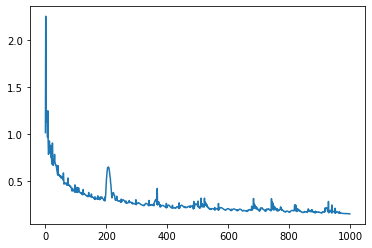

In [10]:
Start_time = time.time()

mean_train_error = 0
mean_test_error = 0
var_test_error = 0

lr_decay = 0.9
num_trials = 1
learning_rate = 5e-3
Num_updates = 1000
losses = torch.zeros(num_trials, r-1, Num_updates)

for s in range(num_trials):
    
    X_train_labeled = [0] * r
    X_test_labeled = [0] * r
    error_train_list_all = []
    error_test_list_all = []

    Start_time_2 = time.time()

    for i in range(r-1): #31-34
        j = i+1

        x = torch.cat((X_train[i], X_train[j]), 0).float()
        y = torch.cat((y_train[i], 
                       torch.zeros(y_train[j].size(), dtype=torch.double)), 0).long()
        
        #mean = torch.mean(x, dim=0)
        #std = torch.std(x, dim=0)
        #x = (x - mean)/std

        N = len(x) # N is batch size
        D_in = len(x[0]) # D_in is input dimension
        H = 500 # H is the dimension of hidden layer
        D_out = 2 # D_out is output dimension
        q = 0.5

        model = torch.nn.Sequential(
                                    torch.nn.Linear(D_in, H),
                                    torch.nn.LeakyReLU(0.01),
                                    #torch.nn.ReLU(),
                                    #torch.nn.Tanh(),
                                    #torch.nn.Dropout(p=q),
                                    torch.nn.Linear(H, D_out)
                                    )

        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        for t in range(Num_updates):
            y_pred = model(x) # of shape (N,D_out)
            loss = loss_fn(y_pred, y)
            losses[s, i, t] = loss

            #if t % 1000 == 0:
            #    print(t, loss.item())
                
            if (t+1) % 1000 == 0:
                optimizer.param_groups[0]['lr'] = lr_decay * learning_rate

            optimizer.zero_grad()

            loss.backward() # Backward pass

            optimizer.step()  # Calling the step function on the Optimizer 

        X = torch.cat((X_test[i], X_test[j]), 0).float()
        Y = torch.cat((y_test[i], torch.zeros(y_test[j].size(), 
                                              dtype=torch.double)), 0).long()
        #X = (X - mean)/std        
        
        Y_pred = model(X)

        error_train_list_all.append(int(sum(abs(torch.argmax(y_pred, axis=1)-y)))/y.shape[0])
        error_test_list_all.append(int(sum(abs(torch.argmax(Y_pred, axis=1)-Y)))/Y.shape[0])

    mean_train_error += np.mean(error_train_list_all)
    mean_test_error += np.mean(error_test_list_all)
    var_test_error += np.var(error_test_list_all)

mean_train_error /= num_trials
mean_test_error /= num_trials
var_test_error /= num_trials

plt.plot((torch.mean(losses[0], dim=0)).detach().numpy())
plt.show()

### New Distance, $|Q|=20$, $\sigma=0.3$

In [16]:
print('|Q|=20,', 'sigma = 0.3,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = LeakyReLU(0.01),", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["Fully Connected 1-Layer", H, None, learning_rate, "len(x)", 
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Hidden dim', 
                                       'Drop Out p', 'Learning Rate',
                                       'Batch Normalization', 'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=20, sigma = 0.3, Number of Users:  41, Number of Trials =  1
Activation = LeakyReLU(0.01), Learning Decay = 0.7 , Number of Updates =  10000


,Classifier,Hidden dim,Drop Out p,Learning Rate,Batch Normalization,Train Error,Test Error,Variance Error
1,Fully Connected 1-Layer,200,None,0.01,len(x),0.0459,0.1679,0.0044


### Old Distance, $|Q|=20$

In [223]:
print('|Q|=20,', 'Old Distance,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Tanh,", "Number of Updates = ", Num_updates)
Dic_1 = {}

models = ["Fully Connected 1-Layer"]

for k in range(len(models)): 
    Dic_1[k+1] = [models[k], H[0], None, learning_rate, "len(x)", 
                  np.round(mean_train_error, decimals = 4), 
                  np.round(mean_test_error, decimals = 4),
                  np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', columns=['Classifier', 'Hidden dim', 
                                                              'Drop Out p', 'Learning Rate',
                                                              'Batch Normalization', 'Train Error', 
                                                              'Test Error', 'Variance Error'])
df_1

|Q|=20, Old Distance, Number of Users:  41, Number of Trials =  1
Tanh, Number of Updates =  10000


,Classifier,Hidden dim,Drop Out p,Learning Rate,Batch Normalization,Train Error,Test Error,Variance Error
1,Fully Connected 1-Layer,20,None,0.005,len(x),0.0683,0.0881,0.0032


### New Distance, $|Q|=50$, $\sigma=0.25$

In [63]:
print('|Q|=50,', 'sigma = 0.25,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = LeakyReLU(0.01),", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["Fully Connected 1-Layer", H, None, learning_rate, "len(x)", 
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Hidden dim', 
                                       'Drop Out p', 'Learning Rate',
                                       'Batch Normalization', 'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=50, sigma = 0.25, Number of Users:  41, Number of Trials =  1
Activation = LeakyReLU(0.01), Learning Decay = 0.8 , Number of Updates =  200


,Classifier,Hidden dim,Drop Out p,Learning Rate,Batch Normalization,Train Error,Test Error,Variance Error
1,Fully Connected 1-Layer,500,None,0.01,len(x),0.008,0.1882,0.0052


### New Distance, $|Q|=50$, $\sigma=1000$

In [12]:
print('|Q|=50,', 'sigma = 1000,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = LeakyReLU(0.01),", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["Fully Connected 1-Layer", H, None, learning_rate, "len(x)", 
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Hidden dim', 
                                       'Drop Out p', 'Learning Rate',
                                       'Batch Normalization', 'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=50, sigma = 1000, Number of Users:  41, Number of Trials =  1
Activation = LeakyReLU(0.01), Learning Decay = 0.8 , Number of Updates =  1000


,Classifier,Hidden dim,Drop Out p,Learning Rate,Batch Normalization,Train Error,Test Error,Variance Error
1,Fully Connected 1-Layer,200,None,0.05,len(x),0.0692,0.2616,0.0084


### Old Distance, $|Q|=50$

In [13]:
print('|Q|=50,', 'Old Distance,', "Number of Users: ", "41,", 'Number of Trials = ', num_trials)
print("Activation = LeakyReLU(0.01),", "Learning Decay =", lr_decay, 
      ", Number of Updates = ", Num_updates)
Dic_1 = {}

Dic_1[1] = ["Fully Connected 1-Layer", H, None, learning_rate, "len(x)", 
              np.round(mean_train_error, decimals = 4), 
              np.round(mean_test_error, decimals = 4),
              np.round(var_test_error, decimals = 4)]
    
df_1 = pd.DataFrame.from_dict(Dic_1, orient='index', 
                              columns=['Classifier', 'Hidden dim', 
                                       'Drop Out p', 'Learning Rate',
                                       'Batch Normalization', 'Train Error', 
                                       'Test Error', 'Variance Error'])
df_1

|Q|=50, Old Distance, Number of Users:  41, Number of Trials =  1
Activation = LeakyReLU(0.01), Learning Decay = 0.4 , Number of Updates =  10000


,Classifier,Hidden dim,Drop Out p,Learning Rate,Batch Normalization,Train Error,Test Error,Variance Error
1,Fully Connected 1-Layer,500,None,0.01,len(x),0.0191,0.0531,0.001
